In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import hydra
from omegaconf import OmegaConf

# add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# initialize hydra

In [3]:
hydra.initialize(config_path="../config", version_base="1.1")

# Choose which config to load
config_name = "config"  # Change this to use a different config
print(f"Loading config: {config_name}")

# Load the config
cfg = hydra.compose(
    config_name=config_name, 
    overrides=["experiment=ops_small"]
)

# Display the loaded config
print(OmegaConf.to_yaml(cfg))

Loading config: config
dataset:
  _target_: datasets.ops.OPSDataset
  set_size: ${experiment.set_size}
  seed: ${seed}
  data_shape:
  - 2
  - 64
  - 64
  prob_spatial: ${experiment.spatial_prob}
  spatial_kernel_width: 10
  replace: true
  pert_embedding_dim: ${experiment.pert_embedding_dim}
encoder:
  _target_: encoder.conv_gnn.ConvDistributionEncoder
  in_channels: ${dataset.data_shape[0]}
  hidden_channels: 32
  out_channels: 32
  hidden_dim: ${experiment.hidden_dim}
  latent_dim: ${experiment.latent_dim}
  num_layers: 2
  kernel_size: 3
  height: ${dataset.data_shape[1]}
  width: ${dataset.data_shape[2]}
  pool_type: mean
  agg_type: mean
model:
  _target_: model.unet_large.ContextUnetLarge
  in_channels: ${dataset.data_shape[0]}
  n_feat: 384
  latent_dim: ${experiment.latent_dim}
  image_size: ${dataset.data_shape[1]}
generator:
  _target_: generator.ddpm.DDPM
  model: ${model}
  betas:
  - 0.0001
  - 0.02
  n_T: 400
  drop_prob: 0.1
  noise_shape: ${dataset.data_shape}
optimize

In [4]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'ops_6e336b49cc39b226a657788a73467c61' in c['name'] 
    and c['generator'] == 'CVAE'
]   


In [5]:
import torch
import hydra

def instantiate_and_load_model(config) -> torch.nn.Module:
    """
    Instantiate and load a model from a checkpoint file.
    
    Args:
        model_path: The path to the model checkpoint file
        device: The device to load the model on

    Returns:
        The loaded model
    """
    cfg = config['config']
    encoder = hydra.utils.instantiate(cfg.encoder)
    generator = hydra.utils.instantiate(cfg.generator)

    checkpoint = torch.load(config['dir'] + '/checkpoint_epoch_1.pt', map_location=device, weights_only=False)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    generator.model.load_state_dict(checkpoint['generator_state_dict'])
    return encoder, generator

enc, gen = instantiate_and_load_model(cfgs[0])

In [6]:
dataset = hydra.utils.instantiate(cfg.dataset)


Dataset initialized:
Total tiles: 38942
Total images: 20872480
Available perturbations: 4961
Holdout perturbations: {'BIRC5', 'RACGAP1', 'PCNA', 'RPA1', 'DONSON', 'UBE2I', 'RRM1', 'MAD2L1'}


In [7]:
import numpy as np
from tqdm import tqdm
def get_all_images_for_perturbation(dataset, perturbation_name, max_images=None, use_tqdm=False):
    """
    Efficiently retrieves all images for a specified perturbation using memory mapping.
    
    Args:
        dataset: An initialized OPSDataset instance
        perturbation_name: The name of the perturbation to retrieve
        max_images: Maximum number of images to return (None for all)
        
    Returns:
        A numpy array of all images for the perturbation
    """
    # Check if perturbation exists
    if perturbation_name not in dataset.pert_indices and perturbation_name not in dataset.heldout_pert_indices:
        available_perts = list(dataset.pert_indices.keys())
        holdout_perts = list(dataset.heldout_pert_indices.keys())
        raise ValueError(f"Perturbation '{perturbation_name}' not found. Available: {available_perts}\nHoldout: {holdout_perts}")
    
    # Get perturbation data
    if perturbation_name in dataset.pert_indices:
        pert_data = dataset.pert_indices[perturbation_name]
    else:
        pert_data = dataset.heldout_pert_indices[perturbation_name]
    
    # Collect images from all tiles
    all_images = []
    image_count = 0
    
    if use_tqdm:
        tile_iter = tqdm(pert_data)
    else:
        tile_iter = pert_data
    for tile_data in tile_iter:
        tile_idx = tile_data['tile_idx']
        local_indices = np.array(tile_data['local_indices'])
        
        # Use memory mapping to only load relevant indices
        tile_path = dataset.tile_paths[tile_idx]
        # Memory-map the file
        mmap_array = np.load(f"{tile_path}/single_cell_images.npy", mmap_mode='r')
        # Only extract the indices we need
        perturbation_images = mmap_array[local_indices]
        all_images.append(perturbation_images)
        
        image_count += len(perturbation_images)
        if max_images is not None and image_count >= max_images:
            # Trim to max_images if specified
            all_combined = np.vstack(all_images)
            return all_combined[:max_images]
    
    # Combine all images
    return np.vstack(all_images)

In [8]:
gene_labels = [
    "UBE2I", "DTL", "LRR1", "DONSON", "RRM1", "ORC1", "SMU1", "RPA1", "PCNA", "MMS22L",
    "DDB1", "POLE", "SF3B3", "PSMA4", "RBX1", "CDC45", "PSMB2", "PSMA1", "SNU13",
    "HINFP", "BIRC5", "CRNKL1", "AURKB", "RACGAP1", "PRC1", "MAD2L1", "TTK", "MTBP",
    "ESPL1"
]


In [9]:
# load all data from image tiles


In [10]:
# get all images for perturbation
# load all perturbations in gene_labels
# shuffled_pert_names = np.random.permutation(list(dataset.pert_indices.keys()))
# pert_images = {}
# for pert in gene_labels + ['nontargeting']:
#     pert_images[pert] = get_all_images_for_perturbation(dataset, pert, use_tqdm=True)
# 


In [11]:
from tqdm import tqdm
from collections import defaultdict

# select random subset of tile paths
tile_paths = dataset.metadata['tile_paths']
tile_idxs = np.random.permutation(len(tile_paths))[:20_000]

images_by_pert = defaultdict(list)

tile_to_pert_idx = {}
for k in dataset.metadata['pert_indices']:
    for i in range(len(dataset.metadata['pert_indices'][k])):
        tile_idx = dataset.metadata['pert_indices'][k][i]['tile_idx']
        if tile_idx not in tile_to_pert_idx:
            tile_to_pert_idx[tile_idx] = {}
        tile_to_pert_idx[tile_idx][k] = dataset.metadata['pert_indices'][k][i]['local_indices']


# load all images
for tile_idx in tqdm(tile_idxs):
    imgs = np.load(f"{tile_paths[tile_idx]}/single_cell_images.npy")
    for pert in tile_to_pert_idx[tile_idx]:
        images_by_pert[pert].append(imgs[tile_to_pert_idx[tile_idx][pert]])

for pert in images_by_pert:
    images_by_pert[pert] = np.vstack(images_by_pert[pert])



100%|██████████| 20000/20000 [06:17<00:00, 52.99it/s]


In [110]:
# import gc and clear memory
import gc
# del imgs, img_lats, img_recs
gc.collect()
torch.cuda.empty_cache()

In [12]:
cfgs = [
    c for c in configs if 'ops' in c['name'] 
    and c['generator'] == 'DDPM' 
]   

In [ ]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

# ops_c66c5547594b6499ce918c9be2faac34 ddpm

import torch
import hydra

def instantiate_and_load_model(config) -> torch.nn.Module:
    """
    Instantiate and load a model from a checkpoint file.
    
    Args:
        model_path: The path to the model checkpoint file
        device: The device to load the model on

    Returns:
        The loaded model
    """
    cfg = config['config']
    encoder = hydra.utils.instantiate(cfg.encoder)
    generator = hydra.utils.instantiate(cfg.generator)

    checkpoint = torch.load(config['dir'] + '/checkpoint_epoch_2.pt', map_location=device, weights_only=False)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    generator.model.load_state_dict(checkpoint['generator_state_dict'])
    return encoder, generator

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'ops_c66c5547594b6499ce918c9be2faac34' in c['name'] 
]   
enc, gen = instantiate_and_load_model(cfgs[0])

enc.to('cuda')
gen.model.to('cuda')

ContextUnetLarge(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(2, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 384, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 384, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 384, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 384, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
      (1): MaxPool2d(kerne

: 

In [ ]:
# preprocess tiff
img_lats = {}
img_recs = {}
proc_by_pert = {}
for pert in tqdm(images_by_pert):
    imgs = images_by_pert[pert][:, :, 20:-20, 20:-20]
    imgs = imgs / 65535
    imgs = 2 * imgs - 1
    imgs = imgs.astype(np.float32)
    if imgs.shape[0] > 1_000:
        imgs = imgs[:1_000]
    imgs = torch.tensor(imgs, dtype=torch.float).to('cuda')
    # imgs = rs(imgs)[None, ...]
    imgs = imgs[None, ...]
    proc_by_pert[pert] = imgs.detach().cpu().numpy()
    img_lats[pert] = enc(imgs).detach().cpu().numpy()

  0%|          | 10/5050 [00:01<10:44,  7.82it/s]

 58%|█████▊    | 2938/5050 [15:36<05:58,  5.89it/s]  

In [115]:
# lat = enc(imgs)
recons_by_pert = {}
for pert in tqdm(gene_labels + ['nontargeting']):
    border = torch.tensor(proc_by_pert[pert][0, :100]).to('cuda')
    rec = gen.sample(
        torch.tensor(img_lats[pert], dtype=torch.float).to('cuda'), 
        num_samples=100, border=border
    )
    recons_by_pert[pert] = rec.detach().cpu().numpy()
    

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


  3%|▎         | 1/30 [00:34<16:54, 34.98s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


  7%|▋         | 2/30 [01:09<16:19, 35.00s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 10%|█         | 3/30 [01:44<15:44, 35.00s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 13%|█▎        | 4/30 [02:19<15:09, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 17%|█▋        | 5/30 [02:54<14:34, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 20%|██        | 6/30 [03:29<13:59, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 23%|██▎       | 7/30 [04:04<13:24, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 27%|██▋       | 8/30 [04:39<12:49, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 30%|███       | 9/30 [05:14<12:14, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 33%|███▎      | 10/30 [05:49<11:39, 34.96s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 37%|███▋      | 11/30 [06:24<11:03, 34.93s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 40%|████      | 12/30 [06:59<10:28, 34.91s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 43%|████▎     | 13/30 [07:34<09:53, 34.89s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 47%|████▋     | 14/30 [08:09<09:18, 34.88s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 50%|█████     | 15/30 [08:44<08:43, 34.88s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 53%|█████▎    | 16/30 [09:19<08:08, 34.88s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 57%|█████▋    | 17/30 [09:53<07:33, 34.89s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 60%|██████    | 18/30 [10:28<06:58, 34.91s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 63%|██████▎   | 19/30 [11:03<06:24, 34.92s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 67%|██████▋   | 20/30 [11:38<05:49, 34.93s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 70%|███████   | 21/30 [12:13<05:14, 34.93s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 73%|███████▎  | 22/30 [12:48<04:39, 34.94s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 77%|███████▋  | 23/30 [13:23<04:04, 34.93s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 80%|████████  | 24/30 [13:58<03:29, 34.96s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 83%|████████▎ | 25/30 [14:33<02:54, 34.97s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 87%|████████▋ | 26/30 [15:08<02:19, 34.98s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 90%|█████████ | 27/30 [15:43<01:44, 34.99s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 93%|█████████▎| 28/30 [16:18<01:09, 35.00s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


 97%|█████████▋| 29/30 [16:53<00:35, 35.00s/it]

torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


100%|██████████| 30/30 [17:28<00:00, 34.96s/it]


In [119]:
heldout_perts = ['BIRC5', 'DONSON', 'UBE2I', 'RACGAP1', 'PCNA', 'RPA1', 'MAD2L1', 'RRM1']

In [120]:
import torch
import matplotlib.pyplot as plt

def fast_batch_edge_widths(images, threshold=-0.93):
    """
    images: Tensor of shape [B, C, H, W] or [B, H, W]
    Returns: Tensor of shape [B, 4] containing (top, bottom, left, right) widths
    """
    if images.dim() == 4:
        images = images.mean(dim=1)  # [B, C, H, W] -> [B, H, W]
    B, H, W = images.shape

    def edge_width_along_axis(imgs, dim):
        """
        imgs: [B, H] or [B, W]
        dim: 1 if vertical (for rows), 2 if horizontal (for cols)
        """
        mask = imgs > threshold  # [B, L]
        flipped_mask = torch.flip(mask, dims=[1])
        idx_first = mask.float().argmax(dim=1)  # first row/col where mask is True
        idx_last = flipped_mask.float().argmax(dim=1)  # same from opposite side
        width_first = idx_first
        width_last = imgs.shape[1] - idx_last - 1
        return width_first, width_last

    # row means (vertical sweep for top/bottom)
    row_means = images.mean(dim=2)  # [B, H]
    top, bottom = edge_width_along_axis(row_means, dim=1)

    # column means (horizontal sweep for left/right)
    col_means = images.mean(dim=1)  # [B, W]
    left, right = edge_width_along_axis(col_means, dim=1)

    return torch.stack([torch.maximum(top, 64 - bottom), torch.maximum(left, 64 - right)], dim=1)  # [B, 4]

def apply_border_mask_vectorized(images, edge_widths, fill_value=-1.0):
    """
    images: Tensor of shape [B, C, H, W]
    edge_widths: Tensor of shape [B, 2] → (top_height, left_width), symmetric
    fill_value: scalar to set at border
    Returns: masked images [B, C, H, W]
    """
    B, C, H, W = images.shape
    device = images.device

    # Compute full border masks for each image in batch
    rows = torch.arange(H, device=device).view(1, 1, H, 1)  # [1, 1, H, 1]
    cols = torch.arange(W, device=device).view(1, 1, 1, W)  # [1, 1, 1, W]

    top = edge_widths[:, 0].view(B, 1, 1, 1)                # [B, 1, 1, 1]
    left = edge_widths[:, 1].view(B, 1, 1, 1)               # [B, 1, 1, 1]

    # Symmetric masks: True where pixel is in the padded border region
    border_mask = (
        (rows < top) | (rows >= (H - top)) |
        (cols < left) | (cols >= (W - left))
    )  # [B, 1, H, W]

    return torch.where(border_mask, torch.tensor(fill_value, dtype=images.dtype, device=device), images)


def show_real_and_generated_grid(real, generated, N=5, cmap='viridis'):
    """
    Display a grid comparing real and generated images.
    
    Args:
        real: [B, 2, H, W] tensor of real images
        generated: [B, 2, H, W] tensor of generated images 
        N: Number of image pairs to display (default: 5)
        cmap: Matplotlib colormap to use (default: 'viridis')
        
    Shows a grid with real images on top row and generated images on bottom row.
    """
    assert real.shape[1] == 2 and generated.shape[1] == 2, "Both must have 2 channels"
    B, _, H, W = real.shape
    N = min(N, B)

    # Create figure with enough width to show images clearly
    fig, axs = plt.subplots(2, N, figsize=(2*N, 4), dpi=100)
    
    # Add row labels with more padding
    fig.text(0.08, 0.75, 'Real', rotation=90, va='center', fontsize=20)
    fig.text(0.08, 0.27, 'Generated', rotation=90, va='center', fontsize=20)

    # Plot images
    for i in range(N):
        # Real image
        axs[0, i].imshow(real[i, 0].detach().cpu().numpy(), cmap=cmap)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        
        # Generated image  
        axs[1, i].imshow(generated[i, 0].detach().cpu().numpy(), cmap=cmap)
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])

    plt.tight_layout(rect=[0.1, 0, 1, 1])  # Add padding on left side
    plt.show()


In [130]:
pert = heldout_perts[4]

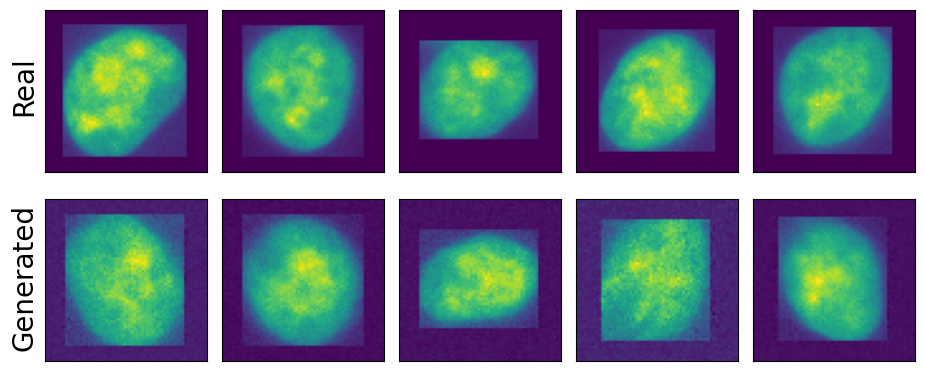

In [131]:
pert_image = torch.tensor(proc_by_pert[pert][0])
pert_recon = torch.tensor(recons_by_pert[pert][0])

show_real_and_generated_grid(pert_image, pert_recon)


In [134]:
def get_border_padding(imgs, center_idx=30):
    x_pad, y_pad = (imgs[:, :, 0, center_idx, :] == -1).sum(axis=-1), (imgs[:, :, 0, :, center_idx] == -1).sum(axis=-1)
    return x_pad, y_pad

In [160]:
nucleus_size = {}
border_size = {}
for pert in tqdm(proc_by_pert):
    nucleus_size[pert] = proc_by_pert[pert][:, 0].mean()
    border_size[pert] = get_border_padding(proc_by_pert[pert])
    # print(pert, nucleus_size[pert], border_size[pert])

100%|██████████| 5050/5050 [00:03<00:00, 1275.87it/s]


In [173]:
import pickle
pert_embeddings = pickle.load(open(f"/orcd/scratch/bcs/001/njwfish/data/ops/genept_gen_rep.pkl", "rb"))
pert_embeddings = {k: np.array(pert_embeddings[k]) for k in pert_embeddings}



In [254]:
pert_names = [k for k in img_lats if (k not in heldout_perts) and (k in pert_embeddings)]
Z = np.vstack([pert_embeddings[k] for k in img_lats if (k not in heldout_perts) and (k in pert_embeddings)])
stacked_lats = np.vstack([img_lats[k] for k in img_lats if (k not in heldout_perts) and (k in pert_embeddings)])
stacked_nuc_size = np.vstack([nucleus_size[k] for k in img_lats if (k not in heldout_perts) and (k in pert_embeddings)])
stacked_border_size = np.vstack([np.hstack([border_size[k][0].mean(), border_size[k][1].mean()]) for k in img_lats if (k not in heldout_perts) and (k in pert_embeddings)])

Z_eval = np.vstack([pert_embeddings[k] for k in heldout_perts if (k in pert_embeddings)])
stacked_lats_eval = np.vstack([img_lats[k] for k in heldout_perts if (k in pert_embeddings)])
stacked_nuc_size_eval = np.vstack([nucleus_size[k] for k in heldout_perts if (k in pert_embeddings)])
stacked_border_size_eval = np.vstack([np.hstack([border_size[k][0].mean(), border_size[k][1].mean()]) for k in heldout_perts if (k in pert_embeddings)])

In [223]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
ridge = Ridge()

In [224]:
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(Z, stacked_lats)
reg = Ridge(alpha=grid_search.best_params_['alpha'])
reg.fit(Z, stacked_lats)
pred_lats_eval = reg.predict(Z_eval).astype(np.float32)

grid_search.fit(Z, stacked_border_size)
reg = Ridge(alpha=0)
reg.fit(Z, stacked_border_size)
pred_border_size_eval = reg.predict(Z_eval).astype(np.float32)

In [255]:
# compute distance between Z and Z_eval
from sklearn.metrics.pairwise import cosine_distances

# Compute pairwise distances between Z and Z_eval
distances = cosine_distances(Z, Z_eval)

# Find the nearest neighbor for each point in Z_eval
nearest_neighbor_indices = np.argmin(distances, axis=0)

nearest_neighbors = {pert: pert_names[nearest_neighbor_indices[i]] for i, pert in enumerate(heldout_perts)}

In [225]:
stacked_border_size_flat = np.hstack([np.vstack([border_size[k][0], border_size[k][1]]) for k in img_lats if (k not in heldout_perts) and (k in pert_embeddings)]).T
cov = np.cov(stacked_border_size_flat, rowvar=False)

In [239]:
def create_border(border_size):
    # Takes border_size as n x 2 array and returns n x 64 x 64 array of masks
    mask = np.ones((border_size.shape[0], 2, 64, 64))
    
    # Calculate x and y border sizes, handling odd numbers
    x_borders_right = (border_size[:, 0] // 2).astype(int)  # Integer division for right side
    x_borders_left = (border_size[:, 0] - x_borders_right).astype(int)  # Extra pixel goes to left if odd
    
    y_borders_bottom = (border_size[:, 1] // 2).astype(int)  # Integer division for bottom
    y_borders_top = (border_size[:, 1] - y_borders_bottom).astype(int)  # Extra pixel goes to top if odd
    
    # Use broadcasting to set borders efficiently
    for i, (x_left, x_right, y_top, y_bottom) in enumerate(
        zip(x_borders_left, x_borders_right, y_borders_top, y_borders_bottom)
    ):
        if x_left > 0:
            mask[i, :, :, :x_left] = -1  # Left border (gets extra pixel if odd)
        if x_right > 0:
            mask[i, :, :, -x_right:] = -1  # Right border
        if y_top > 0:
            mask[i, :, :y_top, :] = -1  # Top border (gets extra pixel if odd)
        if y_bottom > 0:
            mask[i, :, -y_bottom:, :] = -1  # Bottom border
            
    return mask

In [ ]:
# lat = enc(imgs)
pred_by_pert = {}
for i, pert in tqdm(enumerate(heldout_perts)):
    print(i, pert)
    # border_size_samples = np.random.multivariate_normal(pred_border_size_eval[i], cov, size=100)
    # border_size_samples = border_size_samples.astype(int)
    # border_size_samples[border_size_samples < 0] = 0
    # sample 100 indices from border_size[nearest_neighbors[pert]]
    idx = np.random.randint(0, len(border_size[nearest_neighbors[pert]]), size=100)
    border_size_samples = np.vstack(border_size[nearest_neighbors[pert]]).T[idx]
    border = torch.tensor(create_border(border_size_samples)).float().to('cuda')
    rec = gen.sample(
        torch.tensor(pred_lats_eval[i][None, ...], dtype=torch.float).to('cuda'), 
        num_samples=100, border=border
    )
    pred_by_pert[pert] = rec.detach().cpu().numpy()


0it [00:00, ?it/s]

0 BIRC5
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


1it [00:34, 34.97s/it]

1 DONSON
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


2it [01:09, 35.00s/it]

2 UBE2I
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


3it [01:45, 35.03s/it]

3 RACGAP1
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


4it [02:20, 35.03s/it]

4 PCNA
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


5it [02:55, 35.01s/it]

5 RPA1
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


6it [03:29, 34.98s/it]

6 MAD2L1
torch.Size([100, 2, 64, 64]) torch.Size([100, 2, 64, 64]) torch.Size([400, 1, 1, 1]) torch.Size([100, 2, 64, 64])
torch.Size([400, 100, 2, 64, 64])


In [ ]:
pred_nucleus_size = {}
for pert in tqdm(recons_by_pert):
    pred_nucleus_size[pert] = pred_by_pert[pert][:, 0].mean()


100%|██████████| 8/8 [00:00<00:00, 10904.92it/s]


In [ ]:
for pert in tqdm(pred_by_pert):
    print(pert, pred_nucleus_size[pert] - nucleus_size['nontargeting'], nucleus_size[pert] - nucleus_size['nontargeting'])


100%|██████████| 8/8 [00:00<00:00, 55924.05it/s]

BIRC5 -0.0035675168 -0.00064104795
DONSON -0.00071567297 -0.022848725
UBE2I 0.0017681122 -0.027543247
RACGAP1 0.03407085 -0.022057652
PCNA 0.034879684 -0.023534358
RPA1 0.046257794 -0.027265072
MAD2L1 0.07182717 -0.021598876
RRM1 -0.0090228915 -0.0029211044


In [ ]:
BIRC5 -0.0035675168 -0.00064104795
DONSON -0.00071567297 -0.022848725
UBE2I 0.0017681122 -0.027543247
RACGAP1 0.03407085 -0.022057652
PCNA 0.034879684 -0.023534358
RPA1 0.046257794 -0.027265072
MAD2L1 0.07182717 -0.021598876
RRM1 -0.0090228915 -0.0029211044
